In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nengo
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2

### Original Inputs (Hyperactive)

Initial ensembles below showing an input response at level .5, and hyperactive PTSD response at 1.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

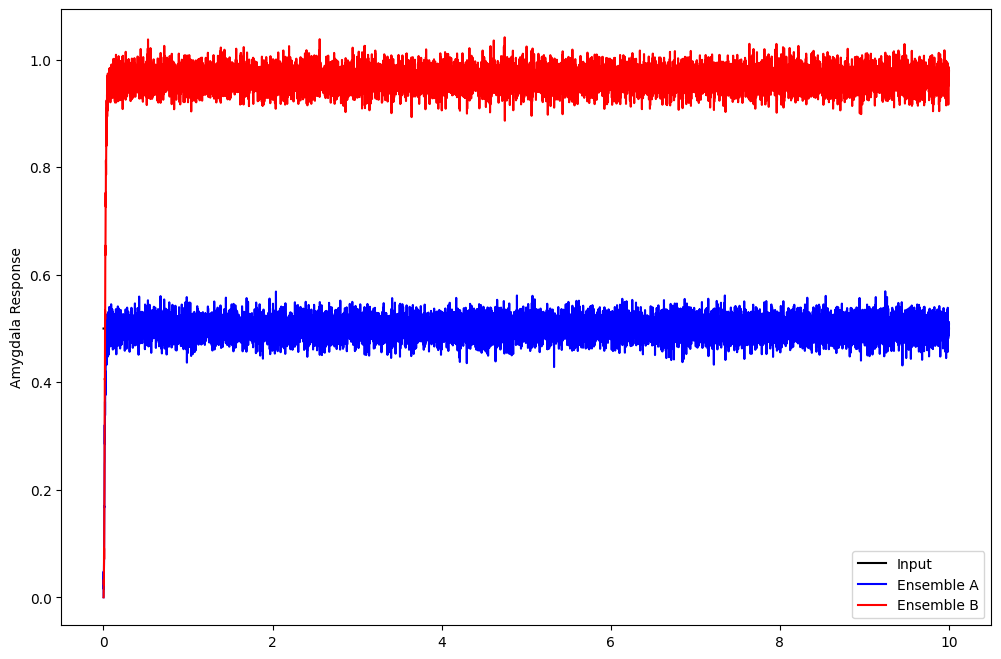

In [4]:
model = nengo.Network(label="Pretrained Hyperactive Response")
with model:
    # input signal, passed from node to ensemble A
    input = nengo.Node(.5)
    A = nengo.Ensemble(60, dimensions=1)
    nengo.Connection(input, A)

    # passed output of ensemble A to ensemble B 
    # train weights with a complicated function (send in a value, return something random)
    B = nengo.Ensemble(60, dimensions=1)
    conn = nengo.Connection(A, B, function=lambda x: 2*x)
    
    inp_p = nengo.Probe(input)
    pre_p = nengo.Probe(A, synapse=0.01)
    post_p = nengo.Probe(B, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(10.0)

plt.figure(figsize=(12, 8))
plt.plot(sim.trange(), sim.data[inp_p].T[0], c="k", label="Input")
plt.plot(sim.trange(), sim.data[pre_p].T[0], c="b", label="Ensemble A")
plt.plot(sim.trange(), sim.data[post_p].T[0], c="r", label="Ensemble B")
plt.ylabel("Amygdala Response")
plt.legend(loc="best")


### Dissociative Response Initial Network (no training) -- Checkpoint #2 Changes

Creating two error connections... Checkpoint #2: need to make a second branch that contains the desired output, which will be .75 times the input.

The difference will be minimized b/t O and desired output block and an additional "desired output ensemble"

In [14]:
# initial model plot (with no learning) - Creating ensembles and connections

import numpy as np

# This class contains the function that first detects a significant pulse and then applies the function that decrements the input over time.
class desiredResponse:
    def __init__(self, dimensions):
        self.history = np.zeros((10, dimensions))
        self.n_pulses = 0
 
    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x

        if self.history[0] - x > .8:
            print('pulse incremented')
            self.n_pulses += 1
       
        self.last_val = x

        return x*(.75)**self.n_pulses # Function that causes decrease by .75 raised to the number of pulses
 
des = desiredResponse(dimensions = 1)
    
model = nengo.Network(label="Dissociative Neurons Pre-Learning")
with model:

    # input signal, passed from node to ensemble A ... 
    input = nengo.Node(Piecewise({0: 0, 1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:1, 8:0})) # Input is a piecewise to show multiple traumatic events.
    I = nengo.Ensemble(200, dimensions=1)
    nengo.Connection(input, I)  # connects input to I
    
    # passed output of ensemble I to ensemble O
    O = nengo.Ensemble(200, dimensions=1) 

    conn = nengo.Connection(I, O) # connecting I to O

    des_node = nengo.Node(des.step, size_in=1, size_out=1)  # desired output is .75 times the input

    # connecting the new node to the input
    nengo.Connection(input, des_node)

    # end of creating the function - end of replacing the function connection with a node

    # creating all the probes

    des_p = nengo.Probe(des_node, synapse=.01) # original error probe, shows the desired output that learning rule will be applied to
    inp_p = nengo.Probe(input, synapse = 0.01) 
    I_p = nengo.Probe(I, synapse=0.01) 
    O_p = nengo.Probe(O, synapse=0.01)

    # creating the simulation

with nengo.Simulator(model) as sim:
    sim.run(10.0)
    


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

pulse incremented
pulse incremented
pulse incremented
pulse incremented


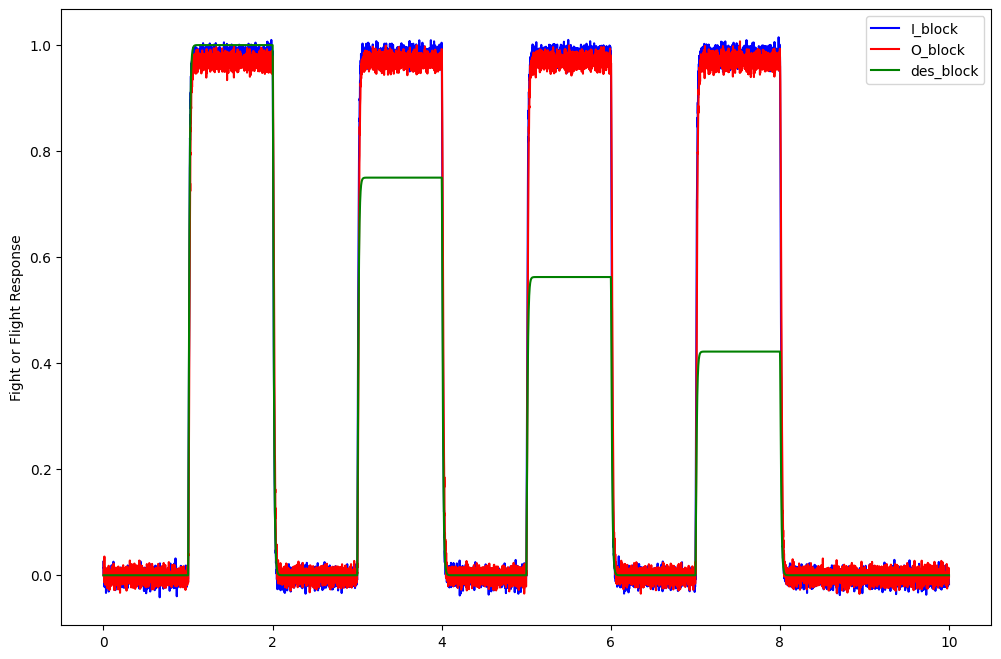

In [18]:

plt.figure(figsize=(12, 8))
plt.plot(sim.trange(), sim.data[I_p].T[0], c="b", label="I_block")
plt.plot(sim.trange(), sim.data[O_p].T[0], c="r", label="O_block")
plt.plot(sim.trange(), sim.data[des_p].T[0], c="g", label="des_block")
plt.ylabel("Fight or Flight Response")
plt.legend(loc="best")
plt.show()

### Implementing Dissociative Learning Rule -> Error differences section (minimize the error to reach a goal)

The new goal is called "des", where previously our goal was input A. In this section I was able to show a single pulse decrease to .75 over time to represent numbing reaction/senses to a single traumatic event. Applying the learning rule makes the output become "des" by minimizing the error between them.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

pulse incremented
pulse incremented
pulse incremented
pulse incremented


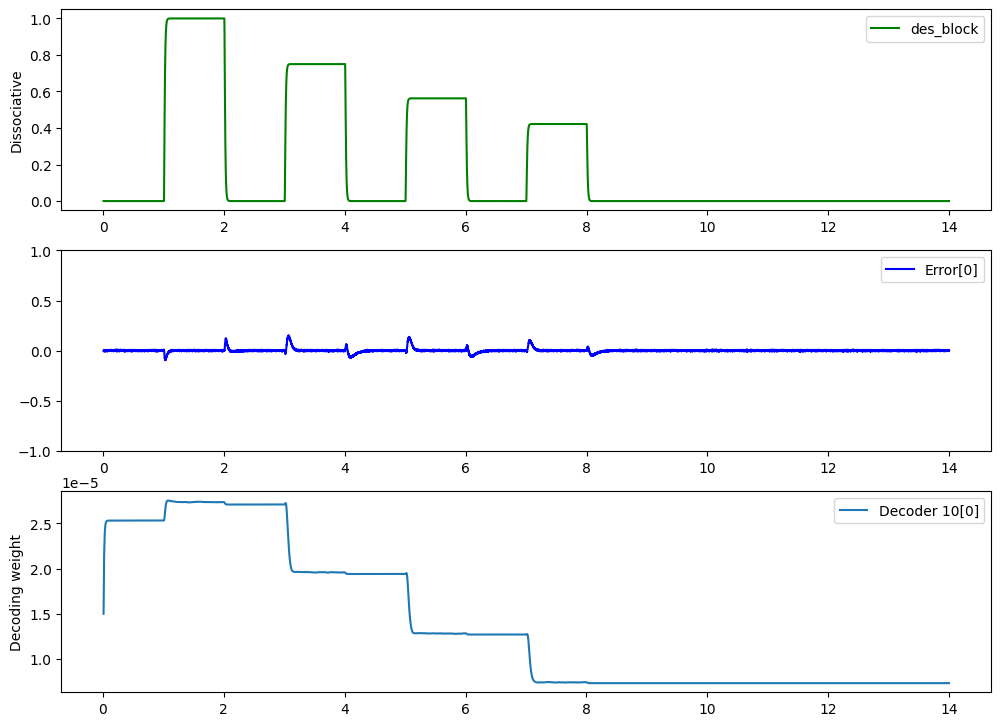

In [23]:
# This is the dissociative response (with learning rule applied)

des.n_pulses = 0

with model:
    error = nengo.Ensemble(200, dimensions=1)
    error_probe = nengo.Probe(error, synapse=0.03)

    # Error = actual - target = post - pre   
    nengo.Connection(des_node, error, transform=-1) 
    nengo.Connection(O, error)

    # Add the learning rule to the connection
    conn.learning_rule_type = nengo.PES()

    # Connect the error into the learning rule
    nengo.Connection(error, conn.learning_rule)
    
    # probe the decoders to see how those change over time to reduce error
    weights_p = nengo.Probe(conn, "weights", synapse=0.01, sample_every=0.01)

    # "run it plot it"

    with nengo.Simulator(model) as sim:
        sim.run(14.0)

plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
plt.plot(sim.trange(), sim.data[inp_p].T[0], c="k", label="Input")
plt.plot(sim.trange(), sim.data[I_p].T[0], c="b", label="Pre")
plt.plot(sim.trange(), sim.data[O_p].T[0], c="r", label="Post")
plt.plot(sim.trange(), sim.data[des_p].T[0], c="g", label="des_block")
plt.ylabel("Dissociative")
plt.legend(loc="best")

plt.subplot(4, 1, 2)
plt.plot(sim.trange(), sim.data[error_probe], c="b")
plt.ylim(-1, 1)
plt.legend(("Error[0]", "Error[1]"), loc="best")
plt.subplot(4, 1, 3)

plt.plot(sim.trange(sample_every=0.01), sim.data[weights_p][...,20])
plt.ylabel("Decoding weight")
plt.legend(("Decoder 10[0]", "Decoder 10[1]"), loc="best")
        
